# 全家便利商店食品輿論分析
- 社群媒體分析
- 授課教授：黃三益
- 組別：Group 7
- 組員：M114020013 黃于千、M114020015 秦苡軒、B084020034 謝旻臻、M114020055 吳均庭
## 大綱
1. About data
    - 1.1 資料基本介紹
    - 1.2 動機及分析方向
2. 資料前處理
    - 2.1 資料匯入
    - 2.2 資料清理
    - 2.3 斷句
    - 2.4 jieba斷詞
    - 2.5 移除停用字
    - 2.6 計算詞頻
    - 2.7 繪製文字雲
    - 2.8 繪製文字雲分析發文數
3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 每日情緒分數
4. CKIP 標註
    + 4.1 將抓取結果用CKIP進行處理
    + 4.2 探索分析 - NER
    + 4.3 探索分析 - POS
5. 利用SnowNLP進行情緒分析
6. TF-IDF
    - 6.1 計算每篇文章的詞數
    - 6.2 計算tf-idf值
    - 6.3 檢視結果
7. 透過結巴斷詞與N-gram幫助建立字典
    - 7.1 Bi-gram
    - 7.2 Bi-gram視覺化

# 1. About data
#### 1.1 資料基本介紹
- 資料來源：
    - 文字平台收集PTT
    - 來源：超商版、飲食疾患版、美食版、省錢版、女孩版
- 搜尋關鍵字：與 **全家美食** 相關的文章<br>
    - 如：全家食物、 全家再睡5分鐘、 全家SOMA、 Let’s Café、 全家署茗職茶...等文章
- 情緒字典：LIWC情緒字典
- 斷詞字典：jieba、CKIP
- 資料時間：2019/01/01 ~ 2023/4/18

#### 1.2 主要分析ptt上文章內容及網友相關討論。本次分析目的及動機主要為：
- 動機：<br>
全家便利商店是許多人生活中常去的店家之一，其所販售的食物種類繁多，不同的人對其評價也各異。<br>
因此，進行全家便利商店食物輿論分析可以幫助我們瞭解消費者對其食品的看法、喜好、意見和需求，進而提供有價值的市場洞察，未來或許可協助全家便利商店了解消費者需求，並持續改進其產品和服務。
- 分析目的：
    1. 瞭解消費者對全家便利商店食品的整體滿意度和評價，包括正面和負面評價。
    2. 分析消費者對全家便利商店食品的評價因素，例如味道、價格、品質、包裝、不同的聯名產品等，以及這些評價因素對消費者滿意度的影響。
    3. 研究消費者對全家便利商店食品的改進建議和期望，了解消費者希望全家便利商店在哪些方面進行改進，以提高產品和服務質量。

## 2. 資料前處理

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import math
from datetime import datetime, timedelta
from collections import Counter, namedtuple

from wordcloud import WordCloud 
from PIL import Image, ImageSequence
import jieba
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
from snownlp import SnowNLP
from nltk import ngrams
from nltk import FreqDist
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="raw_data/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 120

### 2.1 匯入資料

In [4]:
df = pd.read_csv('sna2023sPro_7_737d4b10d8_4.csv')
df = df.rename(columns={"artContent": "sentence"})
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"(如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n【商品名稱/價格】：奧地利咖啡69...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt
1,2,https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87....,[商品]全家咖哩起司豬排堡,2019-01-05 23:39:29,nerolanx,CVS,【商品名稱/價格】：咖哩起司豬排堡/49元\n\n\n【便利商店/廠商名稱】：金家/屏榮食品...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""lucicarr"", ""...",39.10.62.24,2019-03-07 02:32:05,ptt
2,3,https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8....,[討論]全家拿鐵改新配方，容量也變了？,2019-01-08 02:24:34,alwaysky,CVS,自從全家改了黃金配方後，\n原本裝大熱拿剛好的保溫杯，\n（舊版裝完可以旋上杯蓋不溢出來）\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""lemenf1"", ""c...",42.77.174.192,2019-03-07 02:32:05,ptt
3,4,https://www.ptt.cc/bbs/CVS/M.1546995940.A.156....,[分享］全家茶葉蛋買到半熟蛋,2019-01-09 00:59:37,summerhsia,CVS,【便利商店名稱/廠商名稱】：全家便利商店\n\n我其實平常買茶葉蛋不會特別挑\n但最近好幾次...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ConanKo"", ""c...",49.217.39.169,2019-03-07 02:32:05,ptt
4,5,https://www.ptt.cc/bbs/CVS/M.1547045068.A.571....,[商品]全家福袋加萊爾富福袋,2019-01-09 14:38:26,jack99310349,CVS,【商品名稱/價格】：福袋\n s\n【便利商店/廠商名稱】...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mytoychiu"", ...",114.136.100.49,2019-03-07 02:32:27,ptt


### 2.2 清理資料

In [5]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

### 2.3 斷句

In [6]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df["sentence"] = (sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str))
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

### 2.4 jieba斷詞

In [7]:
jieba.set_dictionary("dict/dict.txt")
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from /home/lydiawu/SocialMedia/midterm_project/dict/dict.txt ...
Loading model from cache /tmp/jieba.u618afddca54df41362aceff5f3b40ddf.cache
Loading model cost 0.831 seconds.
Prefix dict has been built successfully.


In [8]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

### 2.5 移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]

In [10]:
noStop_df = word_df[~word_df["word"].isin(stopwords)]
noStop_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,如有
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,清楚
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,項目
1,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,跳過
2,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,CtrlY


### 2.6 計算詞頻

In [11]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df.head(10)

,word,freq
0,全家,1630
1,名稱,1275
2,商品,926
3,價格,811
4,便利商店,715
5,廠商,625
6,熱量,565
7,內容物,528
8,規格,524
9,心得,431


#### 更新停用字

In [12]:
# 參數形式手動加入停用字
stopwords_manual = ["CtrlY", "JPTT", "XD", "Sent", "on", "my","from", "本來", "對面", "剛剛", "裡面", "那種", "這種", "算是", "上面", "現在", 
                    "知道", "一直", "一次", "一口", "一下", "一點", "一杯", "今天", "如有", "項目", "全家", "名稱", "商品", "印象", "以前", 
                    "東西", "還蠻", "iPhone", "希望", "搭配", "這款", "使用", "最近", "附近", "遇到", "看看", "文字",
                    "看到", "發現", "分為", "請問", "之後", "好像", "變成", "跳過", "刪除", "最後", "吃到", "變成", "直接", "目前", "有沒有", "便利商店"]
stopwords.extend(stopwords_manual)

In [13]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]

#### 重新計算詞頻

In [14]:
freq_df_2 = pd.DataFrame({'freq':noStop_df_2.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']  
freq_df_2 = freq_df_2[clist]
freq_df_2.head(10)

,word,freq
0,價格,811
1,廠商,625
2,熱量,565
3,內容物,528
4,規格,524
5,心得,431
6,評分,401
7,霜淇淋,379
8,咖啡,364
9,口味,326


#### 繪製詞頻長條圖

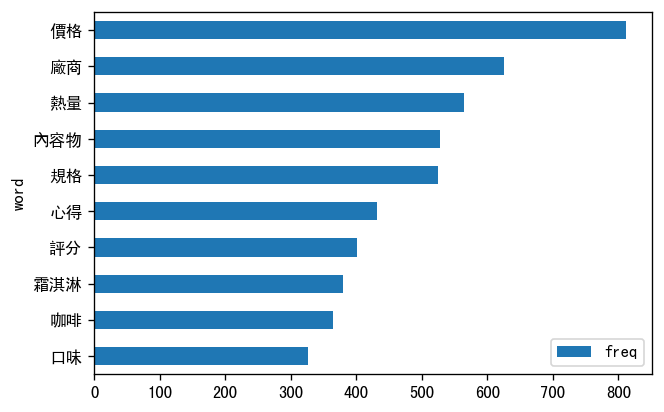

In [15]:
freq_df_2.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

從上面的長條圖可以推測消費者較在意商品的價格、製作廠商及熱量內容物等，而在所有商品中，咖啡及霜淇淋的討論度又是最高的

### 2.7 繪製文字雲

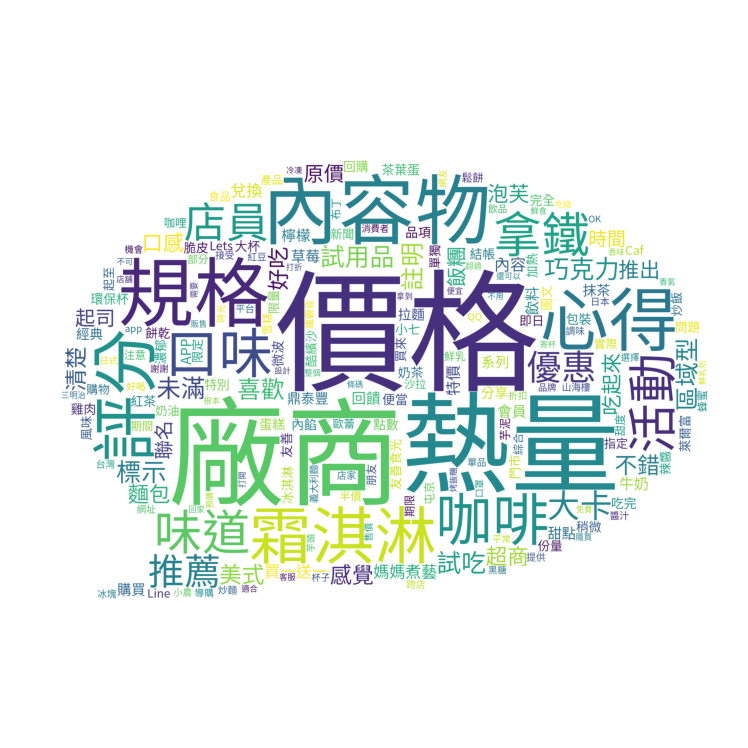

In [16]:
# 詞頻變成dict
freq_dict = freq_df_2.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

#自訂文字雲圖形
mask_cmt = np.array(Image.open("comment.png"))

# 繪製文字雲
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, mask = mask_cmt, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
ptt_df = noStop_df_2.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

### 2.8 分析發文數

In [18]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                            43766
mean     2021-06-14 07:11:39.010510336
min                2019-01-05 08:20:28
25%                2020-06-09 21:39:39
50%                2021-08-09 12:48:19
75%                2022-07-12 11:14:12
max                2023-04-17 22:01:50
Name: artDate, dtype: object

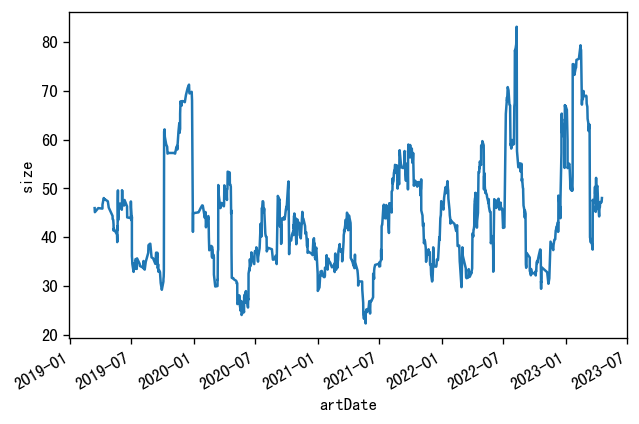

In [19]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 30
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

可以看到資料筆數呈現規律的上升及下降，推測可能是更新聯名商品時，討論度會上升，大部分都集中在下半年，另外，在2023-02時，平均文章數較多

單獨看2023-02時的文字雲

In [20]:
date = "2023-02"
mask = ptt_df[(ptt_df['artDate'].dt.year == pd.Timestamp(date).year)]
mask = mask[(mask['artDate'].dt.month == pd.Timestamp(date).month)]
mask

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
8014,804,https://www.ptt.cc/bbs/CVS/M.1675259840.A.9F4....,[商品]全家布丁狗福袋,2023-02-01 21:57:18,peter1003,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""asos53"", ""cm...",223.140.215.11,2023-02-02 01:04:29,ptt,價格
8014,804,https://www.ptt.cc/bbs/CVS/M.1675259840.A.9F4....,[商品]全家布丁狗福袋,2023-02-01 21:57:18,peter1003,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""asos53"", ""cm...",223.140.215.11,2023-02-02 01:04:29,ptt,布丁
8014,804,https://www.ptt.cc/bbs/CVS/M.1675259840.A.9F4....,[商品]全家布丁狗福袋,2023-02-01 21:57:18,peter1003,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""asos53"", ""cm...",223.140.215.11,2023-02-02 01:04:29,ptt,福袋
8015,804,https://www.ptt.cc/bbs/CVS/M.1675259840.A.9F4....,[商品]全家布丁狗福袋,2023-02-01 21:57:18,peter1003,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""asos53"", ""cm...",223.140.215.11,2023-02-02 01:04:29,ptt,廠商
8016,804,https://www.ptt.cc/bbs/CVS/M.1675259840.A.9F4....,[商品]全家布丁狗福袋,2023-02-01 21:57:18,peter1003,CVS,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""asos53"", ""cm...",223.140.215.11,2023-02-02 01:04:29,ptt,規格
...,...,...,...,...,...,...,...,...,...,...,...
10170,1020,https://www.ptt.cc/bbs/WomenTalk/M.1677136290....,[閒聊]一樣是聯名為何九妹被罵這麼慘？？？,2023-02-23 15:11:28,vndytjrhu,WomenTalk,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""twmarstw7758...",1.165.165.180,2023-02-24 02:44:38,ptt,九妹
10170,1020,https://www.ptt.cc/bbs/WomenTalk/M.1677136290....,[閒聊]一樣是聯名為何九妹被罵這麼慘？？？,2023-02-23 15:11:28,vndytjrhu,WomenTalk,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""twmarstw7758...",1.165.165.180,2023-02-24 02:44:38,ptt,聯名
10170,1020,https://www.ptt.cc/bbs/WomenTalk/M.1677136290....,[閒聊]一樣是聯名為何九妹被罵這麼慘？？？,2023-02-23 15:11:28,vndytjrhu,WomenTalk,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""twmarstw7758...",1.165.165.180,2023-02-24 02:44:38,ptt,很慘
10171,1020,https://www.ptt.cc/bbs/WomenTalk/M.1677136290....,[閒聊]一樣是聯名為何九妹被罵這麼慘？？？,2023-02-23 15:11:28,vndytjrhu,WomenTalk,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""twmarstw7758...",1.165.165.180,2023-02-24 02:44:38,ptt,差別


In [21]:
freq_df_ma = pd.DataFrame({'freq':mask.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df_ma = freq_df_ma[clist]
freq_df_ma.head(10)

,word,freq
0,草莓,7
1,環保,5
2,奧客,5
3,杯子,5
4,價格,5
5,布丁,4
6,福袋,4
7,台酒,4
8,限定,4
9,聯名,4


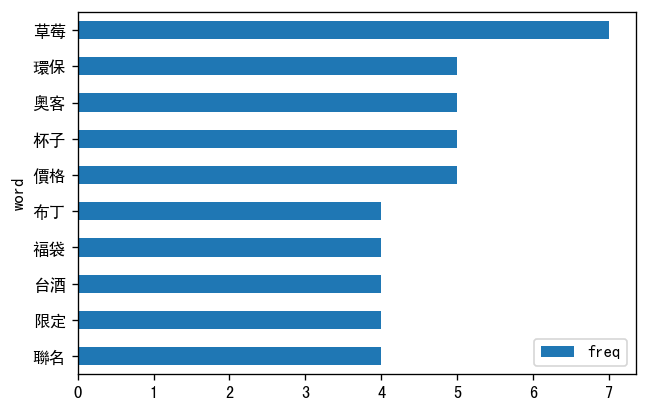

In [22]:
freq_df_ma.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示   
plt.show()

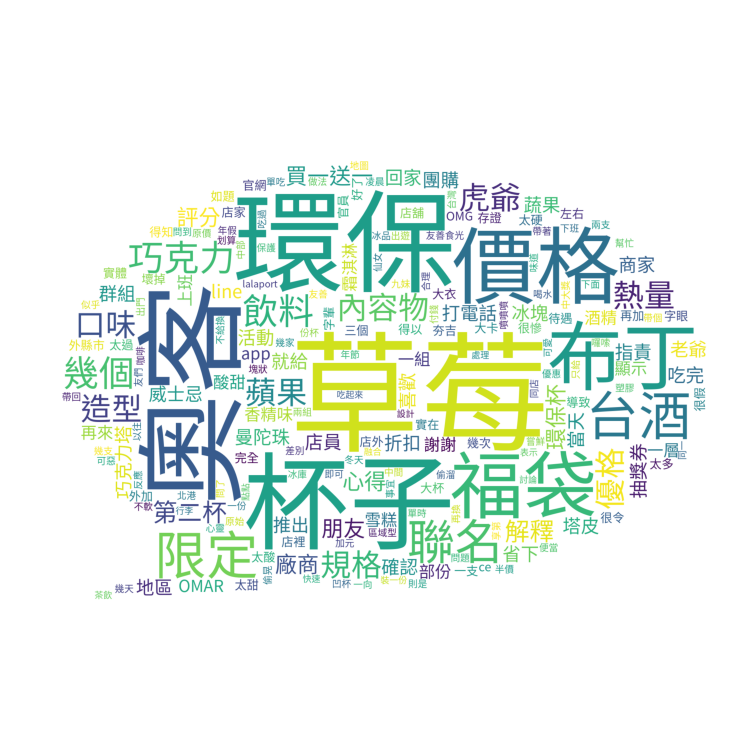

In [23]:
# 詞頻變成dict
freq_dict_ma = freq_df_ma.set_index('word', inplace=False).to_dict()
freq_dict_ma = freq_dict_ma['freq']

# 繪製文字雲
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, mask = mask_cmt, max_words=200)
wordcloud.generate_from_frequencies(freq_dict_ma)
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

可以看到2023-02的文字雲中，有提到福袋、巧克力、草莓等，因此我們推測可能是當時全家有推出一些期間限定的活動，討論度提高。此外，杯子、環保也常被提及，可以發現消費者相當注重環保的議題。

## 3. lexicon-base 情緒分析

### 3.1 準備LIWC字典  

進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

In [24]:
# 讀取情緒字典
liwc_dict = pd.read_csv("dict/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
# liwc_dict.head()

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併

In [25]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2019-01-05 08:20:28,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,清楚,affect
1,2019-01-05 08:20:28,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,清楚,positive
2,2019-01-05 08:20:28,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,NaN
3,2019-01-05 08:20:28,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,奧地利,NaN
4,2019-01-05 08:20:28,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,咖啡,NaN
...,...,...,...,...
46211,2023-03-09 10:36:49,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,金針菇,NaN
46212,2023-03-09 10:36:49,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,沒什麼,NaN
46213,2023-03-09 10:36:49,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,金針菇,NaN
46214,2023-03-09 10:36:49,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,好吃,affect


### 3.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [26]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2019-01-05 08:20:28,affect,4
1,2019-01-05 08:20:28,negative,2
2,2019-01-05 08:20:28,positive,2
3,2019-01-05 08:20:28,NaN,30
4,2019-01-05 23:39:29,NaN,14
...,...,...,...
2720,2023-04-16 23:53:20,anx,1
2724,2023-04-16 23:53:20,NaN,30
2726,2023-04-17 22:01:50,positive,2
2725,2023-04-17 22:01:50,affect,2


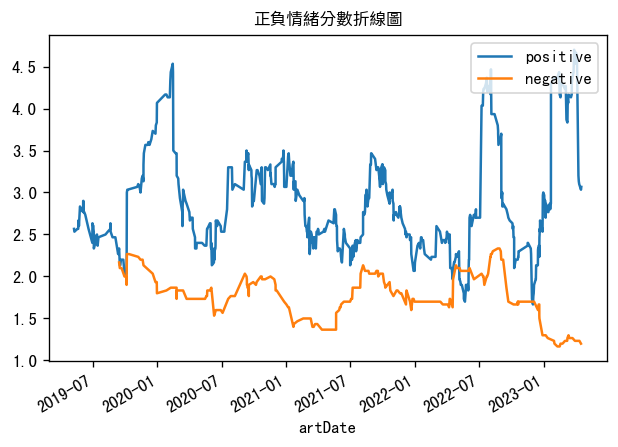

In [27]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 30
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的分數幾乎每天都超過負面，多數而言消費者對全家食物的評價都是較高的

### 3.4 正負向情緒分數比例折線圖

In [28]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2019-01-05 08:20:28,affect,4,0.105263
1,2019-01-05 08:20:28,negative,2,0.052632
2,2019-01-05 08:20:28,positive,2,0.052632
3,2019-01-05 08:20:28,NaN,30,0.789474
4,2019-01-05 23:39:29,NaN,14,1.000000
...,...,...,...,...
2720,2023-04-16 23:53:20,anx,1,0.027778
2724,2023-04-16 23:53:20,NaN,30,0.833333
2726,2023-04-17 22:01:50,positive,2,0.046512
2725,2023-04-17 22:01:50,affect,2,0.046512


In [29]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

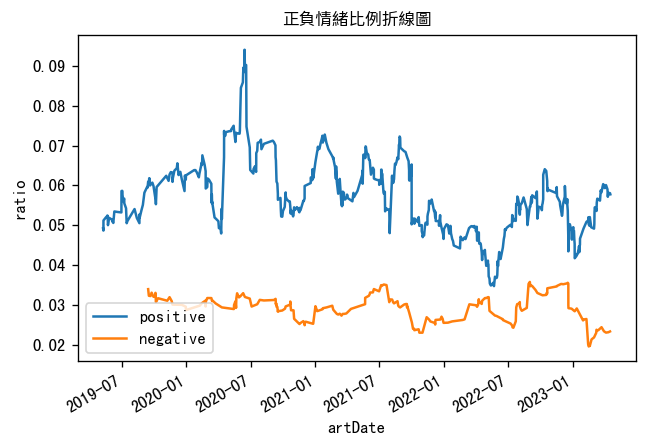

In [30]:
fig, ax = plt.subplots()

rolling_days = 30
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 3.5 文字雲
可以看到2020-06的正向情緒有較明顯的上升，故單看該月的文字雲

In [31]:
ptt_liwc_df["artDate"] = pd.to_datetime(ptt_liwc_df["artDate"])

#### 2020-06

In [32]:
date = "2020-06"
mask1 = ptt_liwc_df[(ptt_liwc_df['artDate'].dt.year == pd.Timestamp(date).year)]
mask1 = mask1[(mask1['artDate'].dt.month == pd.Timestamp(date).month)]
wc = mask1.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

[('店員', 19),
 ('咖啡', 14),
 ('優惠', 12),
 ('問題', 12),
 ('價格', 11),
 ('泡芙', 11),
 ('廠商', 10),
 ('心得', 10),
 ('拿鐵', 10),
 ('清楚', 10),
 ('喜歡', 8),
 ('朋友', 8),
 ('回饋', 7),
 ('熱量', 7),
 ('評分', 7),
 ('內容物', 6),
 ('好吃', 6),
 ('活動', 6),
 ('規格', 6),
 ('味道', 5)]

(-0.5, 2047.5, 2047.5, -0.5)

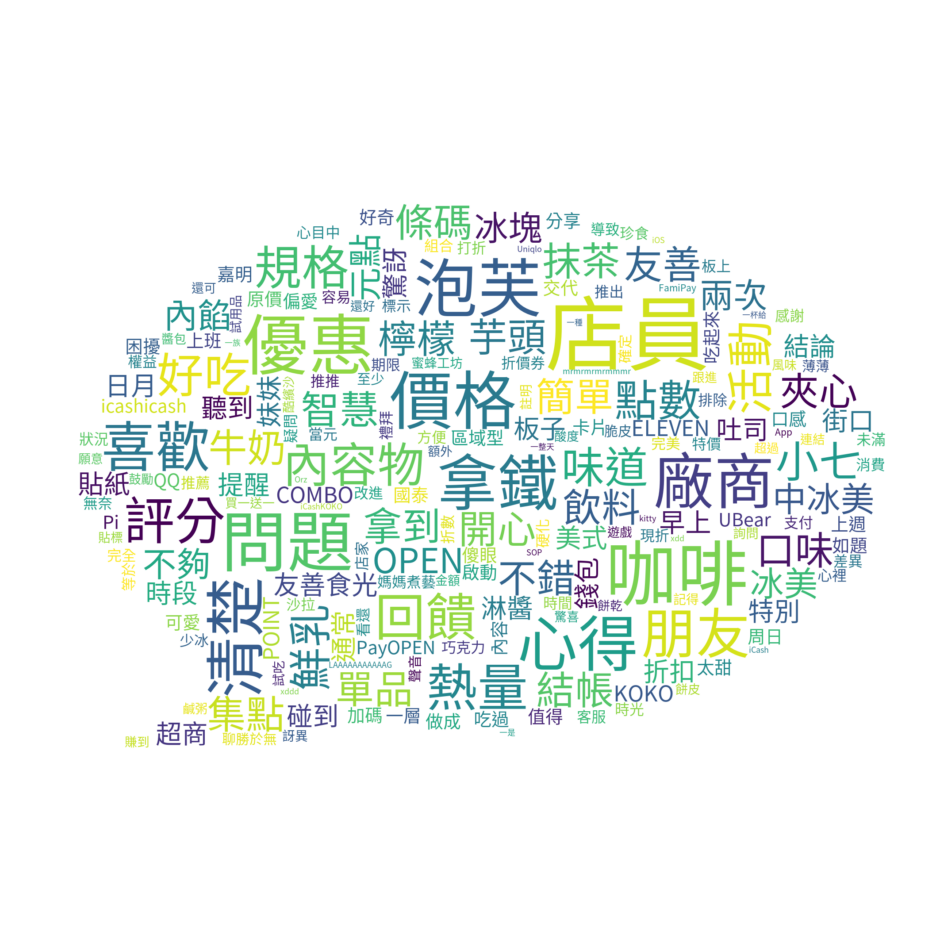

In [33]:
# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, mask = mask_cmt)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(10, 8), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

可以看到這個月最常被提及到的有咖啡、拿鐵等品項，且優惠等詞也經常被提及，推測可能有推出咖啡的優惠，故正向情緒較高

#### 單看正向字

(-0.5, 2047.5, 2047.5, -0.5)

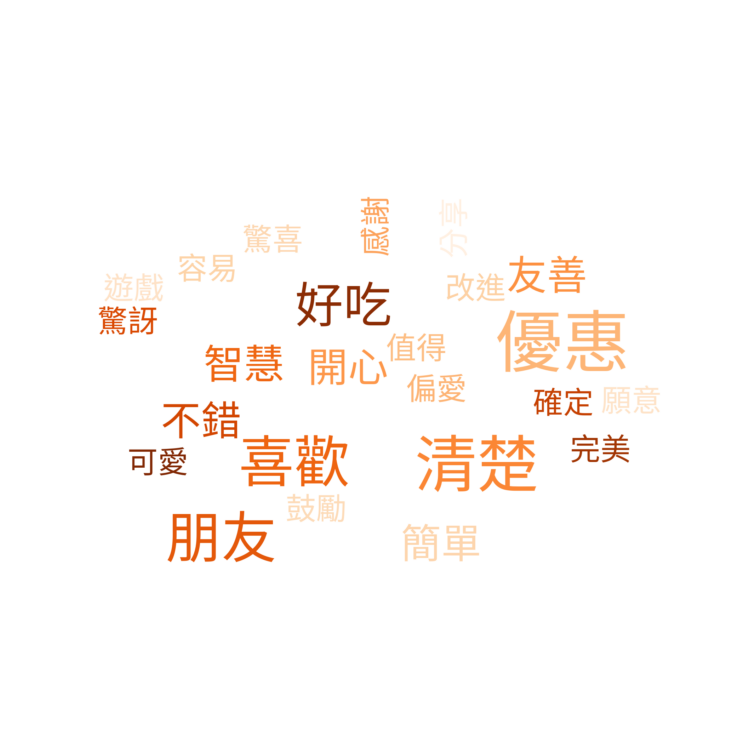

In [34]:
date = "2020-06"
mask1 = ptt_liwc_df[(ptt_liwc_df['artDate'].dt.year == pd.Timestamp(date).year)]
mask1 = mask1[(mask1['artDate'].dt.month == pd.Timestamp(date).month)]
mask1 = mask1[(mask1["sentiments"] == "positive")]


wc = mask1.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, mask = mask_cmt, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(10, 8), dpi=120)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

#### 單看負向字

(-0.5, 2047.5, 2047.5, -0.5)

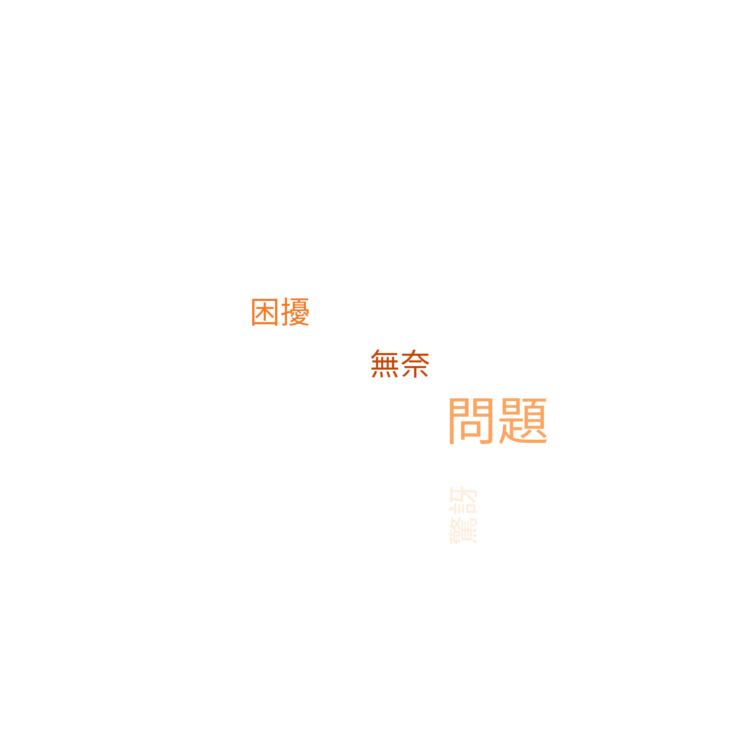

In [35]:
date = "2020-06"
mask1 = ptt_liwc_df[(ptt_liwc_df['artDate'].dt.year == pd.Timestamp(date).year)]
mask1 = mask1[(mask1['artDate'].dt.month == pd.Timestamp(date).month)]
mask1 = mask1[(mask1["sentiments"] == "negative")]


wc = mask1.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, mask = mask_cmt, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(10, 8), dpi=120)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [36]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
76,優惠,positive,191
75,優惠,affect,191
183,喜歡,positive,157
182,喜歡,affect,157
34,不錯,affect,143
...,...,...,...
356,感恩,positive,1
355,感恩,affect,1
350,愉快,positive,1
349,愉快,affect,1


In [37]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.sort_values(["size"], ascending=False)

,word,sentiments,size
76,優惠,positive,191
183,喜歡,positive,157
35,不錯,positive,143
515,清楚,positive,140
237,好吃,positive,136
...,...,...,...
715,贏得,positive,1
717,走運,positive,1
641,美化,positive,1
663,舒適,positive,1


In [38]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.sort_values(["size"], ascending=False)

,word,sentiments,size
177,問題,negative,50
185,單獨,negative,41
633,缺點,negative,18
227,失望,negative,15
619,空虛,negative,15
...,...,...,...
189,嚴峻,negative,1
540,為難,negative,1
406,掙扎,negative,1
542,無味,negative,1


/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, '負向情緒總數')

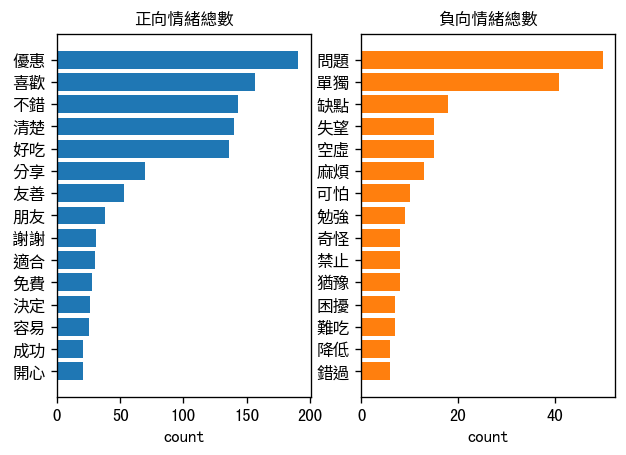

In [39]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 3.7 每日情緒分數趨勢

In [40]:
sentiment_count

,artDate,sentiments,size,ratio
0,2019-01-05 08:20:28,affect,4,0.105263
1,2019-01-05 08:20:28,negative,2,0.052632
2,2019-01-05 08:20:28,positive,2,0.052632
3,2019-01-05 08:20:28,NaN,30,0.789474
4,2019-01-05 23:39:29,NaN,14,1.000000
...,...,...,...,...
2720,2023-04-16 23:53:20,anx,1,0.027778
2724,2023-04-16 23:53:20,NaN,30,0.833333
2726,2023-04-17 22:01:50,positive,2,0.046512
2725,2023-04-17 22:01:50,affect,2,0.046512


In [41]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2019-01-05 08:20:28,4,0,0,2,2,0
1,2019-01-08 02:24:34,3,0,0,2,1,1
2,2019-01-09 00:59:37,1,0,0,0,1,0
3,2019-01-10 05:38:08,1,0,0,0,1,0
4,2019-01-10 08:13:24,1,0,1,1,0,1


In [42]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2019-01-05 08:20:28,4,0,0,2,2,0,0
1,2019-01-08 02:24:34,3,0,0,2,1,1,-2
2,2019-01-09 00:59:37,1,0,0,0,1,0,1
3,2019-01-10 05:38:08,1,0,0,0,1,0,1
4,2019-01-10 08:13:24,1,0,1,1,0,1,-3


/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


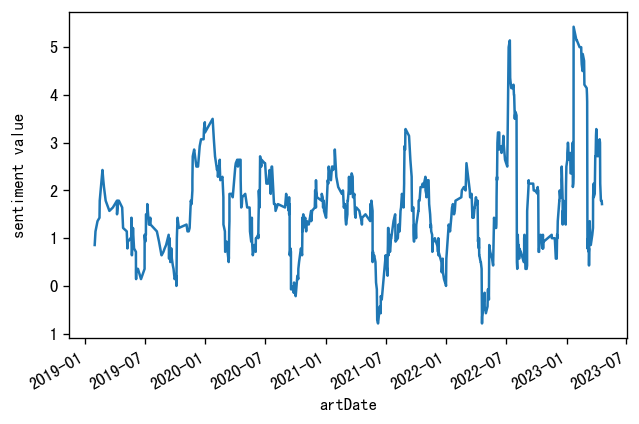

In [43]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

在2022-06及2023-02時，正向情緒最高

## 4. CKIP

###  4.1 CKIP 處理相關function

In [44]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

In [45]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [46]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dictionary2 = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dictionary2)
print(dictionary2)

[(1, {'茶': 500.0}), (2, {'全家': 500.0, '便當': 500.0, '飯團': 500.0, '食物': 500.0, '美食': 500.0, '食品': 500.0, '飲料': 500.0, '咖啡': 500.0, '沙拉': 500.0, '滴妹': 500.0, '千千': 500.0, '雙月': 500.0, '屯京': 500.0, '雞球': 500.0}), (3, {'茶葉蛋': 500.0, '冰淇淋': 500.0, '霜淇淋': 500.0, '古娃娃': 500.0, '鮮乳坊': 500.0, '金針菇': 500.0, '鼎泰豐': 500.0, '新馬辣': 500.0, '山海樓': 500.0, '炎亞綸': 500.0, '這群人': 500.0, '海底撈': 500.0, '添好運': 500.0, '筆尖麵': 500.0, '酷繽沙': 500.0, '蔥拉餅': 500.0, '蔥抓餅': 500.0, '可樂餅': 500.0, '麻辣燙': 500.0}), (4, {'便利商店': 500.0, '微波食品': 500.0, '蜜蜂工坊': 500.0, 'SOMA': 500.0, 'kiri': 500.0, '署茗職茶': 500.0, '媽媽煮藝': 500.0, '友善食光': 500.0}), (5, {'再睡五分鐘': 500.0, '再睡5分鐘': 500.0}), (6, {'癒人節2.0': 500.0}), (8, {'minimore': 500.0})]


In [47]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in tqdm(data_df.iterrows()): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [48]:
pos_table, entity_table, sentence_table = get_nlp_result(sent_df)

9763it [17:12,  9.46it/s]

time costing: 1032.4874956607819


In [49]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,如,Cbb
1,1,有,V_2
2,1,不,D
3,1,清楚,VH
4,1,的,DE


In [50]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,奧地利,GPE
1,1,加新貴派,ORG
2,1,奧地利,GPE
3,2,金家屏榮,PERSON
4,4,今天,DATE


In [51]:
sentence_table.head()

,system_id,sentence
0,1,如有不清楚的項目
1,1,可跳過
2,1,或按刪除商品名稱價格奧地利咖啡特價
3,1,但我買在原價新貴派牛乳單買優惠組合加新貴派本體試吃試用品請標註元便利商店廠商名稱全家
4,1,規格內容物熱量奧地利咖啡卡布奇諾圖文內容請務必圖文獨立不可單獨貼網址或單獨文字內容


In [52]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") 
print(f"posts have NER: {len(entity_table['system_id'].unique())}")

total posts numbers: 994
posts have NER: 701


In [53]:
# # # 將文章存成csv
# pos_table.to_csv('raw_data/pos_table.csv', index = False)
# entity_table.to_csv('raw_data/entity_table.csv', index = False)
# sentence_table.to_csv('raw_data/sentence_table.csv', index = False)

### 4.2 探索分析 - NER

In [54]:
entity_table['ner'].unique()

array(['GPE', 'ORG', 'PERSON', 'DATE', 'CARDINAL', 'NORP', 'PRODUCT',
       'TIME', 'ORDINAL', 'MONEY', 'PERCENT', 'FAC', 'QUANTITY', 'LOC',
       'LAW', 'LANGUAGE', 'WORK_OF_ART', 'EVENT'], dtype=object)

In [55]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
1,DATE,581
0,CARDINAL,447
4,GPE,310
11,ORG,253
13,PERSON,251
14,PRODUCT,236
9,NORP,184
16,TIME,135


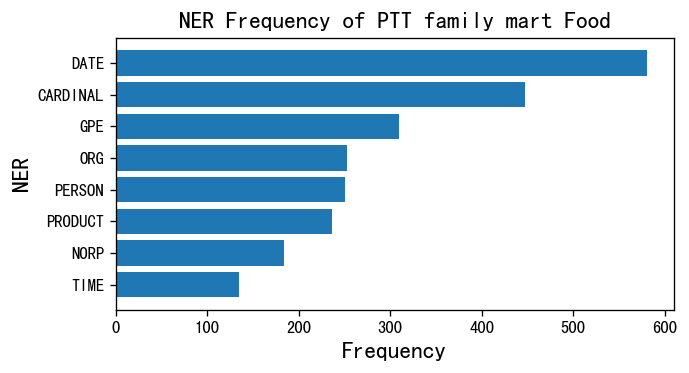

In [56]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(6, 3))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT family mart Food', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

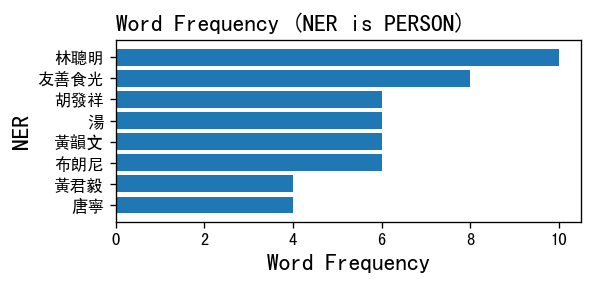

In [57]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(5, 2))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到最常被提及的為友善時光，其為全家的促銷活動，被認為是人名，另外如湯、布朗尼等也被誤認為人名

### 涉及到的組織(ORG)

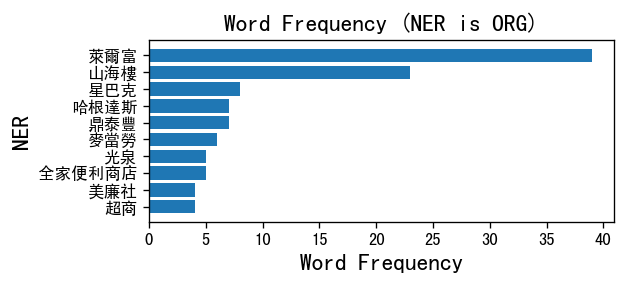

In [58]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(5, 2))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到在多數的文章中，萊爾富被提及的次數最多，可能經常被拿來做比較，此外山海樓的被提次數也很多，可以推斷是叫被關注的聯名商店

### 涉及到的民族、宗教、政治團體(NORP)

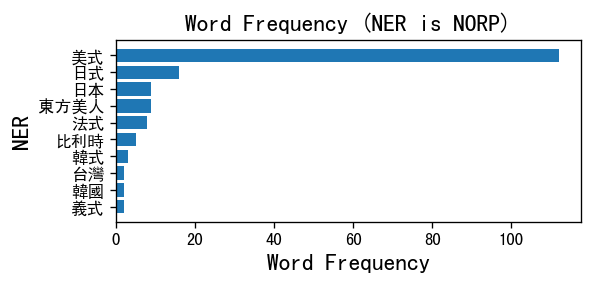

In [59]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(5, 2))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以發現美式的被提及次數最多，推測可能很多是指美式咖啡

查看與美式相關的文章確認

In [60]:
keyword_list = ['美式']
thailand_selected = df[df['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head(3)

美式：72篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource
13,14,https://www.ptt.cc/bbs/CVS/M.1548204572.A.227....,[情報]全家咖啡優惠活動,2019-01-23 00:43:29,tengobo,CVS,"(如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n\n【活動名稱】：全家咖啡活動\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""AAsoon"", ""cm...",110.26.62.219,2019-03-07 02:33:54,ptt
16,17,https://www.ptt.cc/bbs/CVS/M.1548730520.A.FF9....,[情報]全家咖啡HG點數兌換,2019-01-29 02:49:17,YOU770509,CVS,【活動名稱】：happygo點數換全家咖啡\n\n【便利商店/廠商名稱】：全家\n\n【活動...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""happy94277"",...",42.72.232.93,2019-03-07 02:33:54,ptt
17,18,https://www.ptt.cc/bbs/CVS/M.1548809419.A.9C0....,Re:[情報]全家咖啡HG點數兌換,2019-01-30 00:44:16,miniuser,CVS,:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n過去看到美式跟拿鐵是用同一...,[],42.72.232.93,2019-03-07 02:34:24,ptt


可以發現幾乎都是與咖啡相關的文章

### 4.3 探索分析 - POS
#### POS 種類分析
查看辨識出哪幾種POS<br>

In [61]:
pos_table['pos'].unique()

array(['Cbb', 'V_2', 'D', 'VH', 'DE', 'Na', 'VCL', 'Caa', 'P', 'VC', 'Nc',
       'Nh', 'Da', 'VJ', 'VF', 'Nb', 'Ncd', 'VA', 'Di', 'Ng', 'VHC', 'Nd',
       'Neu', 'Nf', 'A', 'SHI', 'Dfa', 'VK', 'VE', 'VD', 'T', 'Neqa',
       'Nep', 'I', 'VL', 'Dk', 'Nes', 'VB', 'Nv', 'Cba', 'FW', 'VG',
       'Cab', 'VI', 'VAC', 'Dfb', 'DM', 'Neqb', 'PARENTHESISCATEGORY'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [62]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,26941
5,D,10203
35,VC,7754
41,VH,5747
6,DE,3598
25,Nf,3027
29,P,2297
17,Nc,2210
9,Dfa,1968
4,Cbb,1923


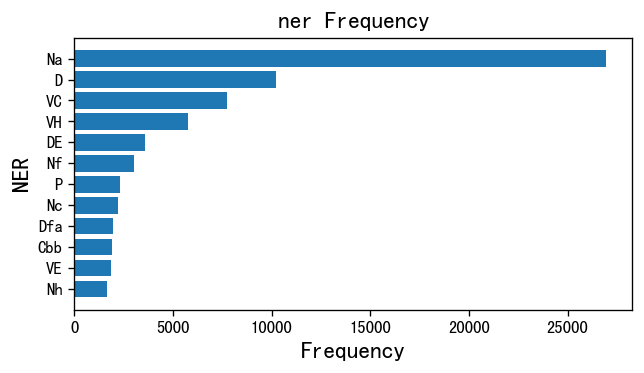

In [63]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(6, 3))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論全家食物時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [64]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
52,全家,241
40,價格元,160
457,鼎泰豐,74
145,小七,47
340,萊爾富,43
82,友善食光,20
53,全盈,17
137,媽媽煮藝,16
102,哈根達斯,13
204,星巴克,12


可以發現鼎泰豐等較受關注的聯名商品。此外，也可以發現711萊爾富等其他便利商店經常一起被提及

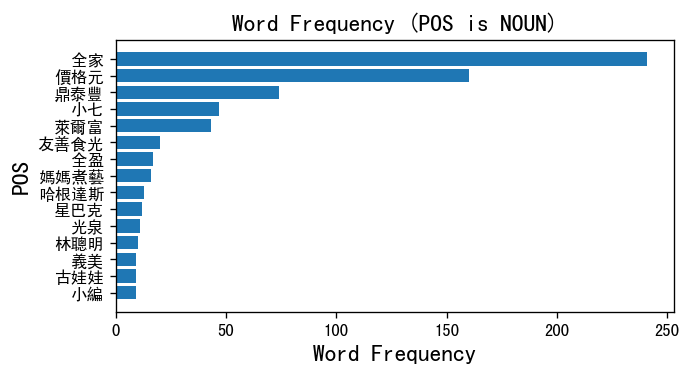

In [65]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(6, 3))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)
+ 我們可以找出談論全家食物時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [66]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
424,推薦,196
541,標示,176
806,試吃,152
84,刪除,146
416,推出,121
151,吃到,98
50,兌換,91
22,使用,75
861,購買,73
209,回饋,57


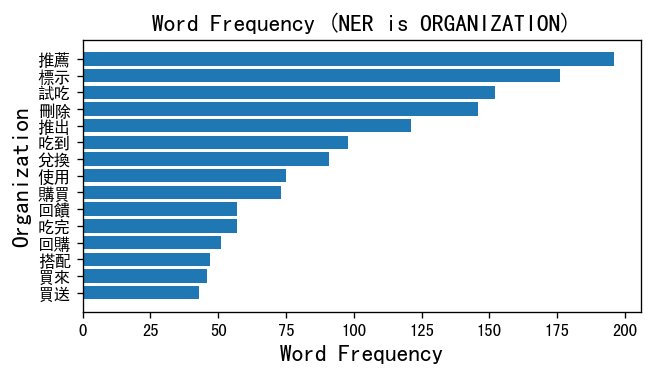

In [67]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(6, 3))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)', size = 14)
ax.set_ylabel('Organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「推薦」佔了相當高的頻率，其他還有出現「試吃」、「吃完」、「回饋」等詞彙，可推測其他人的評價會對民眾的購買慾望帶來很高的影響

## 5. 利用SnowNLP進行情緒分析

有關美式的文章的情緒分析

In [68]:
sentence_table = pd.read_csv("./sna2023sPro_7_737d4b10d8_4.csv") #匯資料

sentiment_date = pd.merge(sentence_table,thailand_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,artUrl,artTitle,artDate_x,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource_x,artDate_y,dataSource_y
13,14,https://www.ptt.cc/bbs/CVS/M.1548204572.A.227....,[情報]全家咖啡優惠活動,2019-01-23 00:43:29,tengobo,CVS,"(如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n\n【活動名稱】：全家咖啡活動\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""AAsoon"", ""cm...",110.26.62.219,2019-03-07 02:33:54,ptt,2019-01-23 00:43:29,ptt
16,17,https://www.ptt.cc/bbs/CVS/M.1548730520.A.FF9....,[情報]全家咖啡HG點數兌換,2019-01-29 02:49:17,YOU770509,CVS,【活動名稱】：happygo點數換全家咖啡\n\n【便利商店/廠商名稱】：全家\n\n【活動...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""happy94277"",...",42.72.232.93,2019-03-07 02:33:54,ptt,2019-01-29 02:49:17,ptt
17,18,https://www.ptt.cc/bbs/CVS/M.1548809419.A.9C0....,Re:[情報]全家咖啡HG點數兌換,2019-01-30 00:44:16,miniuser,CVS,:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n過去看到美式跟拿鐵是用同一...,[],42.72.232.93,2019-03-07 02:34:24,ptt,2019-01-30 00:44:16,ptt
26,27,https://www.ptt.cc/bbs/CVS/M.1551062039.A.E18....,[問題]關於咖啡濃度的問題,2019-02-25 02:27:55,ornvQ,CVS,大家好\n 想來詢問一下咖啡濃度的問題\n\n 我一直以來覺得咖啡最濃的是小七的北海道特調...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""marx0126"", ""...",112.104.85.187,2019-03-07 02:35:38,ptt,2019-02-25 02:27:55,ptt
45,46,https://www.ptt.cc/bbs/CVS/M.1558442124.A.F71....,[商品]全家蜂蜜鮮奶茶全家鬆餅,2019-05-21 12:29:22,phoinixa,CVS,【商品名稱/價格】：蜂蜜鮮奶茶（嘗鮮價 $35）\n 全家鬆餅（$42，可...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""greta1994"", ...",123.205.227.124,2019-05-22 14:50:14,ptt,2019-05-21 12:29:22,ptt


In [69]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['artContent'],), axis = 1)
sentiment_date.head()

,system_id,artUrl,artTitle,artDate_x,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource_x,artDate_y,dataSource_y,sentimentValue
13,14,https://www.ptt.cc/bbs/CVS/M.1548204572.A.227....,[情報]全家咖啡優惠活動,2019-01-23 00:43:29,tengobo,CVS,"(如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n\n【活動名稱】：全家咖啡活動\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""AAsoon"", ""cm...",110.26.62.219,2019-03-07 02:33:54,ptt,2019-01-23 00:43:29,ptt,7.145052e-03
16,17,https://www.ptt.cc/bbs/CVS/M.1548730520.A.FF9....,[情報]全家咖啡HG點數兌換,2019-01-29 02:49:17,YOU770509,CVS,【活動名稱】：happygo點數換全家咖啡\n\n【便利商店/廠商名稱】：全家\n\n【活動...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""happy94277"",...",42.72.232.93,2019-03-07 02:33:54,ptt,2019-01-29 02:49:17,ptt,4.291178e-04
17,18,https://www.ptt.cc/bbs/CVS/M.1548809419.A.9C0....,Re:[情報]全家咖啡HG點數兌換,2019-01-30 00:44:16,miniuser,CVS,:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n:\n過去看到美式跟拿鐵是用同一...,[],42.72.232.93,2019-03-07 02:34:24,ptt,2019-01-30 00:44:16,ptt,9.999998e-01
26,27,https://www.ptt.cc/bbs/CVS/M.1551062039.A.E18....,[問題]關於咖啡濃度的問題,2019-02-25 02:27:55,ornvQ,CVS,大家好\n 想來詢問一下咖啡濃度的問題\n\n 我一直以來覺得咖啡最濃的是小七的北海道特調...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""marx0126"", ""...",112.104.85.187,2019-03-07 02:35:38,ptt,2019-02-25 02:27:55,ptt,1.672656e-08
45,46,https://www.ptt.cc/bbs/CVS/M.1558442124.A.F71....,[商品]全家蜂蜜鮮奶茶全家鬆餅,2019-05-21 12:29:22,phoinixa,CVS,【商品名稱/價格】：蜂蜜鮮奶茶（嘗鮮價 $35）\n 全家鬆餅（$42，可...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""greta1994"", ...",123.205.227.124,2019-05-22 14:50:14,ptt,2019-05-21 12:29:22,ptt,4.261270e-02


In [70]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    7.200000e+01
mean     9.960701e-02
std      2.786720e-01
min      0.000000e+00
25%      3.370082e-13
50%      8.496769e-07
75%      3.513421e-03
max      9.999998e-01
Name: sentimentValue, dtype: float64

<AxesSubplot:>

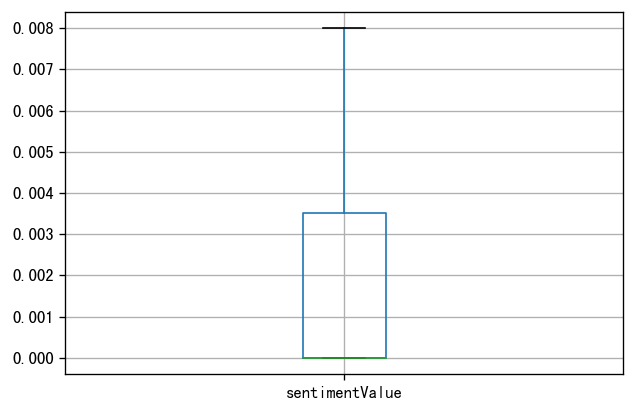

In [71]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [72]:
sent_date = sentiment_date.copy()
sent_date['artDate_x'] =  pd.to_datetime(sentiment_date['artDate_x']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate_x'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate_x,sentimentValue
0,2019-01,3.358580e-01
1,2019-02,1.672656e-08
2,2019-03,9.999977e-01
3,2019-05,4.261270e-02
4,2019-06,1.567457e-01


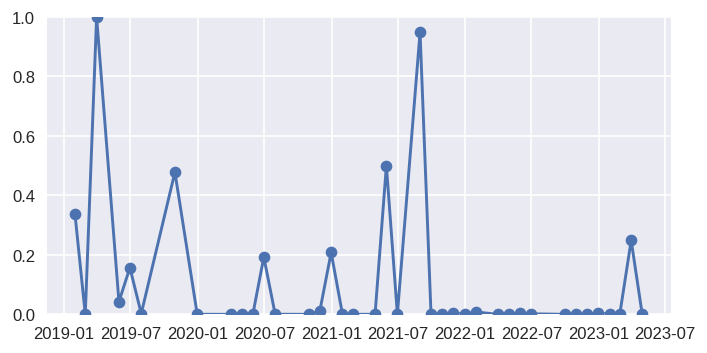

In [73]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate_x']
y = sentiment_count['sentimentValue']

fig, ax = plt.subplots(figsize =(6, 3))
plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.1~0.5之間，偏向負面，我們挑出 2019年6月 來分析。

### 詞彙探索
從上圖中可以發現 2019年06月 的情緒分數相對低，我們把這個月的負面句子挑出來看看他們都用甚麼詞。

In [74]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate_x']=='2019-05']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]
filter_sentiment

,system_id,artUrl,artTitle,artDate_x,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource_x,artDate_y,dataSource_y,sentimentValue
45,46,https://www.ptt.cc/bbs/CVS/M.1558442124.A.F71....,[商品]全家蜂蜜鮮奶茶全家鬆餅,2019-05,phoinixa,CVS,【商品名稱/價格】：蜂蜜鮮奶茶（嘗鮮價 $35）\n 全家鬆餅（$42，可...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""greta1994"", ...",123.205.227.124,2019-05-22 14:50:14,ptt,2019-05-21 12:29:22,ptt,0.042613


In [75]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,46,0.042613,商品
1,46,0.042613,名稱
2,46,0.042613,價格
3,46,0.042613,蜂蜜
4,46,0.042613,鮮


In [76]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]
neg_words

,system_id,sentimentValue,word
0,46,0.042613,商品
1,46,0.042613,名稱
2,46,0.042613,價格
3,46,0.042613,蜂蜜
8,46,0.042613,鮮價
...,...,...,...
187,46,0.042613,本人
188,46,0.042613,所以
193,46,0.042613,餡料
195,46,0.042613,產品


### 負面詞彙文字雲

In [77]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()
# print(stop_words[0:100])

(-0.5, 2047.5, 2047.5, -0.5)

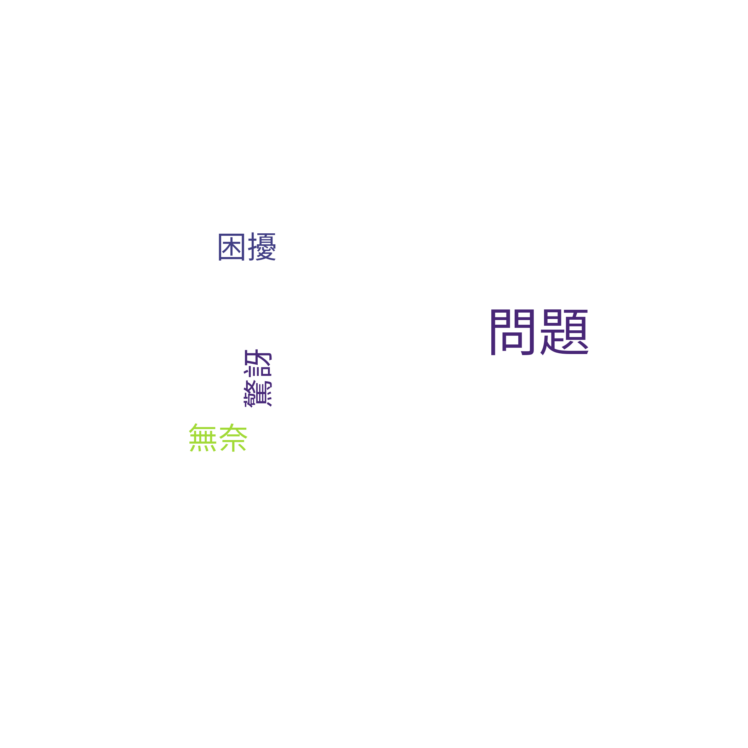

In [78]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(stopwords_manual)
stop_words_pos = set(stop_words_pos)
neg_words = neg_words[~neg_words['word'].isin(stop_words_pos)]

freq_df_2 = pd.DataFrame({'freq':neg_words.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']  
freq_df_2 = freq_df_2[clist]
# 詞頻變成dict
freq_dict = freq_df_2.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']
# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, mask = mask_cmt)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(10, 8), dpi=120)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

資訊量不高，從該負向字來看，推測為店員製作咖啡時造成消費者的負面情緒

## 6. TF-IDF
### 6.1 計算每篇文章的 總詞彙數 與 各個詞彙數

In [79]:
# 每篇文章的總詞彙數
total_words = ptt_df.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,34
1,https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87....,14
2,https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8....,38
3,https://www.ptt.cc/bbs/CVS/M.1546995940.A.156....,17
4,https://www.ptt.cc/bbs/CVS/M.1547045068.A.571....,31
...,...,...
989,https://www.ptt.cc/bbs/WomenTalk/M.1671438687....,11
990,https://www.ptt.cc/bbs/WomenTalk/M.1671472991....,60
991,https://www.ptt.cc/bbs/WomenTalk/M.1672821006....,21
992,https://www.ptt.cc/bbs/WomenTalk/M.1677136290....,14


In [80]:
# 計算各詞彙在各文章中出現的次數
word_count = ptt_df.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1
...,...,...,...
33847,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,聯名,1
33848,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,蠻大,1
33849,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,跟上,1
33850,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,金針菇,2


#### 合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [81]:
family_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
family_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1,34
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1,34
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1,34
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2,34
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1,34
...,...,...,...,...
33847,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,聯名,1,11
33848,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,蠻大,1,11
33849,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,跟上,1,11
33850,https://www.ptt.cc/bbs/WomenTalk/M.1678329411....,金針菇,2,11


### 6.2 計算 tf-idf 值

In [82]:
# 計算tf
family_words_tf_idf = family_words.assign(tf = family_words.iloc[:,2]/family_words.iloc[:,3])
family_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1,34,0.029412
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1,34,0.029412
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1,34,0.029412
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2,34,0.058824
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1,34,0.029412


In [83]:
# 計算每個詞彙出現在幾篇文章中
idf_df = family_words.groupby(['word'],as_index=False).size()
family_words_tf_idf = family_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
family_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1,34,0.029412,26
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1,34,0.029412,561
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1,34,0.029412,69
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2,34,0.058824,69
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1,34,0.029412,497


In [84]:
# 計算idf
family_words_tf_idf = family_words_tf_idf.assign(idf = family_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))
family_words_tf_idf = family_words_tf_idf.drop(labels=['size'],axis=1)
family_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1,34,0.029412,1.582413
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1,34,0.029412,0.248424
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1,34,0.029412,1.158537
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2,34,0.058824,1.158537
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1,34,0.029412,0.301030


In [85]:
# 計算tf*idf
family_words_tf_idf = family_words_tf_idf.assign(tf_idf = family_words_tf_idf.iloc[:,4] * family_words_tf_idf.iloc[:,5])
family_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,不可,1,34,0.029412,1.582413,0.046542
1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,價格,1,34,0.029412,0.248424,0.007307
2,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,優惠,1,34,0.029412,1.158537,0.034075
3,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容,2,34,0.058824,1.158537,0.068149
4,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,內容物,1,34,0.029412,0.301030,0.008854


### 6.3 檢視結果

In [86]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = family_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                              
https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5.html 13  奧地利  0.176317
                                                   15   新貴  0.176317
                                                   9    單獨  0.098539
                                                   11   圖文  0.094085
                                                   12   奇諾  0.088158
https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87.html 32   堡元  0.214099
                                                   33   屏榮  0.153735
                                                   39   豬排  0.149593
                                                   29   先上  0.145939
                                                   31   咖哩  0.128090
https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8.html 42  保溫杯  0.212870
                                                   69   配方  0.212870
                                                   57   改了  0.157757
                                                   43  倒進去  0.078879
                                                   44  先換個  0.078879

#### 計算整個文集中較常 tf-idf 值高的字

In [87]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(family_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
957,內容物,89
3487,熱量,79
877,價格,77
4322,規格,66
4964,霜淇淋,62
2212,廠商,54
1251,區域型,52
4355,註明,49
3238,活動,47
3283,清楚,44


## 7. 透過結巴斷詞與N-gram幫助建立字典
### 7.1 Bi-gram

In [88]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt.big")
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from /home/lydiawu/SocialMedia/midterm_project/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ueb9b1b4ec31dffaf204f0ea833cfd011.cache
Loading model cost 1.501 seconds.
Prefix dict has been built successfully.


In [89]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [90]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [91]:
family_bigram = sent_df.copy()
family_bigram["word"] = family_bigram.sentence.apply(bigram_getToken)
family_bigram = family_bigram.explode('word')
family_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,如有不清楚的項目,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,NaN
1,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,可跳過,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,NaN
2,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,或按 CtrlY 刪除商品名稱價格奧地利咖啡特價,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,商品名稱 價格


#### 統計最常出現的bigram組合

In [92]:
# 計算每個組合出現的次數
family_bigram_count = family_bigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的bigram組合
fb_filter = list(family_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
family_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
6882,商品名稱 價格,584
20367,規格 內容,519
3651,內容 熱量,519
20665,試吃 試用品,174
20671,試用品 標示,173
14132,標示 價格,173
4975,區域 註明,169
20575,註明 試吃,169
15410,滿分 推薦,167
3106,價格 廠商,157


### 7.2 Bi-gram視覺化

In [93]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stop_words and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [94]:
family_bigram2 = sent_df.copy()
family_bigram2["word"] = family_bigram2.sentence.apply(bigram_getToken_dict)
family_bigram2 = family_bigram2.explode('word')
family_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,如有不清楚的項目,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,NaN
1,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,可跳過,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,NaN
2,1,https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....,[商品]全家奧地利咖啡、新貴派牛乳,2019-01-05 08:20:28,DoubleKang,CVS,或按 CtrlY 刪除商品名稱價格奧地利咖啡特價,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betaku"", ""cm...",61.230.200.184,2019-03-07 02:31:37,ptt,商品名稱 價格


In [95]:
bigramfdist.most_common(5)

[(('商品名稱', '價格'), 584),
 (('規格', '內容'), 519),
 (('內容', '熱量'), 519),
 (('試吃', '試用品'), 174),
 (('試用品', '標示'), 173)]

In [96]:
# 建立bigram和count的dictionary
d = {k:v for k,v in bigramfdist.most_common(50)}

# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

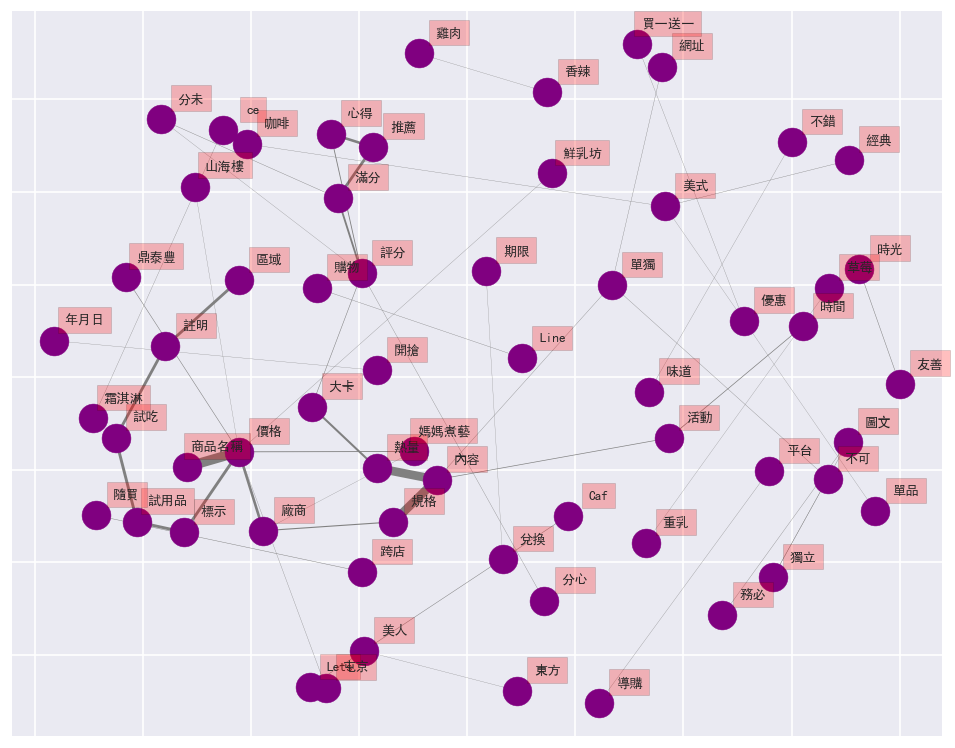

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=8)
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示   
plt.show()

## Summary：
- 可以看出有話題集中在：
    1. 食品飲料的內容、熱量、規格等
    2. 早餐時段的友善時光、Let's Café
    3. 推薦心得、評分等評價

- 評價：
    1. 正面：回購機率高（如：回購、好吃、友善、親切...等）
    2. 負面：推測為店員服務態度差（如：缺點、難吃、失望、勉強...等）
    
- 建議：
    1. 建議可以加強教育訓練，提升服務態度
    2. 聯名商品推出時，需要更嚴格把關
    3. 適時推出更多適合的優惠活動，增加消費者購買率及討論度